# Data Science

Debido al requerimiento del cliente, se procederan a reordenar la data, para obtener un set de datos horarios donde cada fila represente la cantidad de viajes realizados en esa hora en especifico(hora de comienzo del viaje).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from lightgbm import LGBMRegressor
from skforecast.model_selection import backtesting_forecaster
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from funciones import normalize
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
df = pd.read_parquet('Data\process_taxis.parquet',engine='pyarrow')

In [3]:
df.set_index(keys='pickup_datetime',inplace=True)

In [12]:
# Crear un nuevo DataFrame con la cantidad de registros por hora
df_hour = df.resample('30min').size().to_frame('travels')

In [6]:
df_hour.tail(2)

,travels
pickup_datetime,
2024-06-30 23:30:00,818
2024-07-01 00:00:00,2


### <center>Models</center>

Para cumplir con las expectativas del cliente, se evaluaran 2 modelos

- Forecaster Autoregresive: 

Para modelar la evolución de los datos como serie de tiempo, se optó por un modelo Forecaster Autoregresivo que incorpora lags de la variable objetivo y variables de tiempo (como la hora, mes, dia, etc). Esta elección se fundamenta en la hipótesis de que los valores futuros de la serie están fuertemente influenciados por sus valores pasados y por patrones estacionales o cíclicos asociados a las variables de tiempo.

Los lags permiten capturar la autocorrelación presente en la serie, mientras que las variables de tiempo ayudan a modelar los componentes estacionales y de tendencia, lo que resulta en predicciones más precisas y robustas.
Luego de esto se evaluara el desempeño del modelo para su comparacion.

- Modelo de Predicción en Cascada(Autoregresion y Random Forest o regresion lineal multiple):

Para realizar predicciones futuras de la variable objetivo, el modelo se desarrollará en dos etapas. En la primera etapa, se utilizarán modelos predictivos para estimar los valores futuros de las variables auxiliares (ganancia neta, duración del viaje, y CO₂ emitido). Estas estimaciones serán generadas únicamente a partir de valores pasados de cada una de las variables auxiliares, aplicando un modelo autoregresivo puro. Así, para cada variable auxiliar, se entrenará un modelo autoregresivo independiente que capture las tendencias y patrones de su serie temporal individual sin depender de otras variables.

En la segunda etapa, las estimaciones futuras de estas variables auxiliares se utilizarán como entradas (features) en el modelo final. Este modelo tendrá como objetivo principal la predicción de la variable objetivo y empleará tanto los valores estimados de las variables auxiliares como el valor pasado de la variable objetivo para optimizar su precisión en las predicciones futuras. 

******

### <center>Target</center>

El desafio al cual nos ha sometido el cliente, es predecir la demanda de taxis, para lo cual es necesario saber o estimar un valor de cuantos viajes pudieran llegar a realizarse. Por lo cual, se utilizara como target la columna "viajes" creada a partir del recuento de instancias de nuestra data principal transformada en un dataframe con frecuencia horaria.



In [66]:
df.columns

Index(['dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID',
       'DOLocationID', 'total_price', 'service', 'fuel_type',
       'energy_consumption', 'fuel_cost', 'trip_duration', 'labor', 'co2',
       'maintenance', 'net_profit'],
      dtype='object')

In [7]:
sum_for_price = df['total_price'].resample('30min').sum().to_frame('total_price')
sum_for_cost = df['fuel_cost'].resample('30min').sum().to_frame('fuel_cost')
sum_for_profit = df['net_profit'].resample('30min').sum().to_frame('net_profit')
sum_for_duration = df['trip_duration'].resample('30min').sum().to_frame('trip_duration')
sum_for_distance = df['trip_distance'].resample('30min').sum().to_frame('trip_distance')
sum_for_co2 = df['co2'].resample('30min').sum().to_frame('co2')

In [9]:
print(sum_for_price.dtypes)
print(sum_for_cost.dtypes)
print(sum_for_profit.dtypes)
print(sum_for_duration.dtypes)
print(sum_for_distance.dtypes)
sum_for_co2.dtypes

total_price    float64
dtype: object
fuel_cost    float64
dtype: object
net_profit    float64
dtype: object
trip_duration    float64
dtype: object
trip_distance    float64
dtype: object


co2    float64
dtype: object

In [13]:
df_hour = df_hour.join([sum_for_price,sum_for_cost,sum_for_profit,sum_for_duration,sum_for_distance])

In [14]:
df_hour

,travels,total_price,fuel_cost,net_profit,trip_duration,trip_distance
pickup_datetime,,,,,,
2023-01-01 00:00:00,1853,47979.22,395.191741,40904.556504,406.908889,6846.976
2023-01-01 00:30:00,2517,66286.79,576.180912,56303.368866,568.035556,9762.960
2023-01-01 01:00:00,2319,62007.80,544.498246,52805.492954,518.825000,9239.184
2023-01-01 01:30:00,2224,58375.04,546.593933,49788.835101,470.569167,9017.136
2023-01-01 02:00:00,2035,53229.55,505.169056,45693.233555,404.129722,8479.472
...,...,...,...,...,...,...
2024-06-30 22:00:00,1337,31547.81,279.424093,26865.990574,262.873333,4667.760
2024-06-30 22:30:00,1158,27133.76,242.651104,23144.853607,222.342222,4145.312
2024-06-30 23:00:00,902,21163.91,199.414637,18051.228108,170.396389,3411.280


In [15]:
df_hour.reset_index(inplace=True)
df_hour['year'] = df_hour['pickup_datetime'].dt.year
df_hour['quarter'] = df_hour['pickup_datetime'].dt.quarter
df_hour['month'] = df_hour['pickup_datetime'].dt.month
df_hour['day_month'] = df_hour['pickup_datetime'].dt.day
df_hour['weekday'] = df_hour['pickup_datetime'].dt.dayofweek
df_hour['hour'] = df_hour['pickup_datetime'].dt.hour
df_hour['weekend'] = df_hour['pickup_datetime'].apply(lambda x: x.weekday() < 5).astype(int) # 1 = weekday, 0 = weekend
#df_hour.drop(columns=['pickup_datetime','dropoff_datetime'],inplace=True)
df_hour.set_index(keys='pickup_datetime',inplace=True)

# Correlation

Antes de comenzar a implementar los modelos, analizaremos las correlaciones y autocorrelaciones de las diversas variables.

Como nuestro target es la cantidad de viajes realizados en ese determinado momento(ya sea por hora o media hora) se procederan a analizar las correlaciones de esa variable con las variables de tiempo y tambien con nuestras otras variables.

In [16]:
df_hour.columns

Index(['travels', 'total_price', 'fuel_cost', 'net_profit', 'trip_duration',
       'trip_distance', 'year', 'quarter', 'month', 'day_month', 'weekday',
       'hour', 'weekend'],
      dtype='object')

#### Time variables

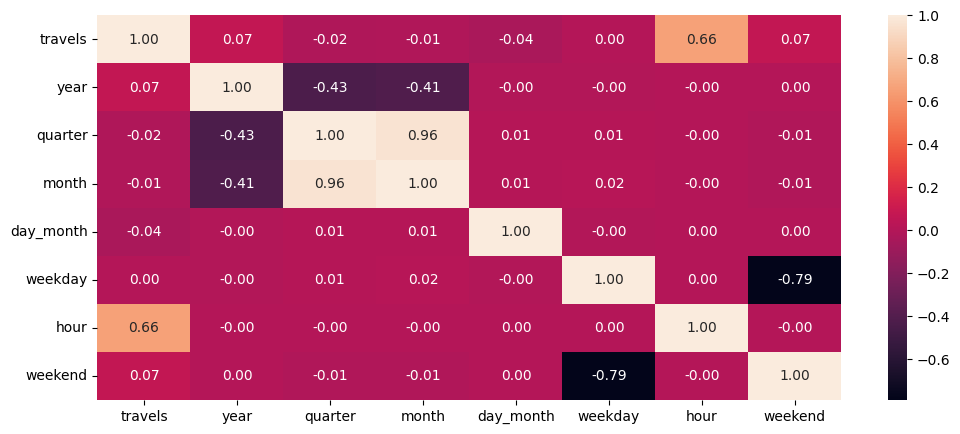

In [82]:
corr = df_hour[['travels', 'year', 'quarter', 'month', 'day_month',
       'weekday', 'hour', 'weekend']].corr(method='spearman')
plt.figure(figsize=(12,5))
sns.heatmap(data=corr,annot=True,fmt='.2f')
plt.show()

Se observa que para nuestro target, la variable mas relevante es la hora.

#### Auxiliary variables

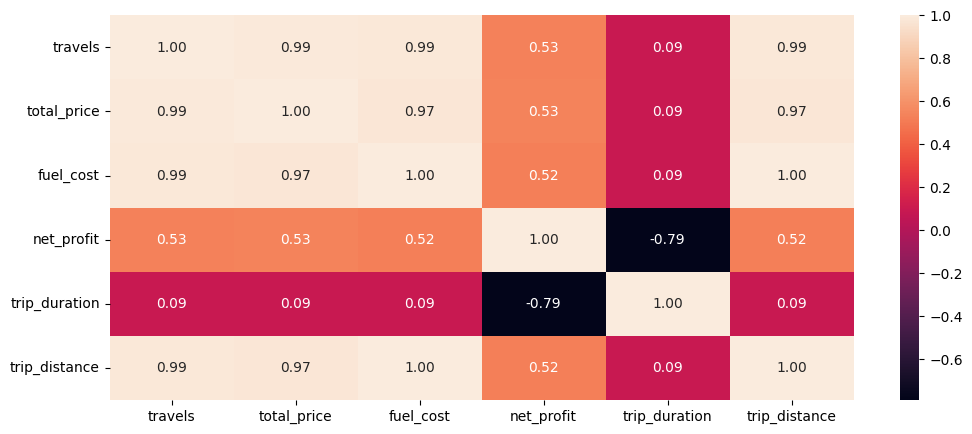

In [84]:
corr = df_hour[['travels', 'total_price', 'fuel_cost', 'net_profit', 'trip_duration',
       'trip_distance']].corr(method='pearson')
plt.figure(figsize=(12,5))
sns.heatmap(data=corr,annot=True,fmt='.2f')
plt.show()

Se ve una correlacion casi perfecto lo que estaria indicando un posible descarte de esas variables para nuestro modelo. La unica variable en este caso relevante podria considerarse que es la ganancia neta.

# Autocorrelation

In [85]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

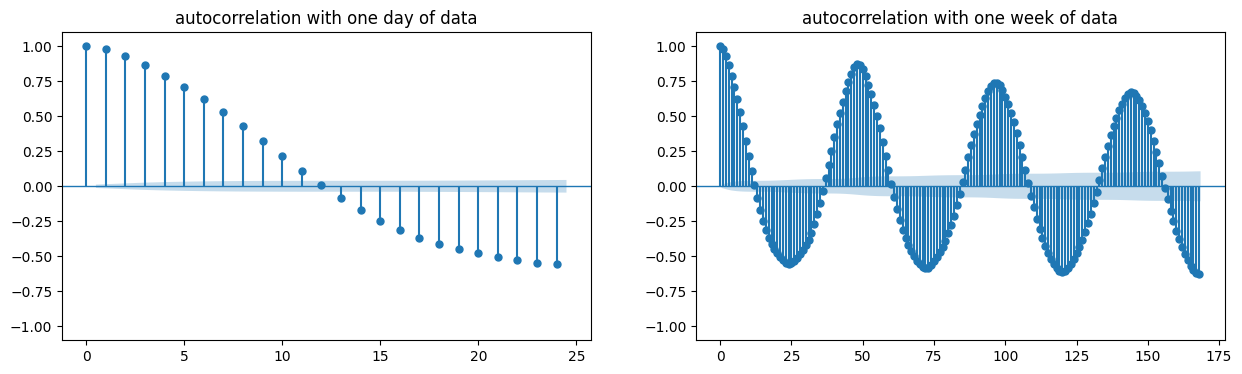

In [86]:
# Gráfico autocorrelación
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes = axes.flat
plot_acf(df_hour.travels, ax=axes[0], linewidth = 1, lags=24)
axes[0].set_title("autocorrelation with one day of data")
axes[0].set_ylim(-1.1, 1.1)
plot_acf(df_hour.travels, ax=axes[1], linewidth = 1, lags=168)
axes[1].set_title("autocorrelation with one week of data")
axes[1].set_ylim(-1.1, 1.1)
plt.show()

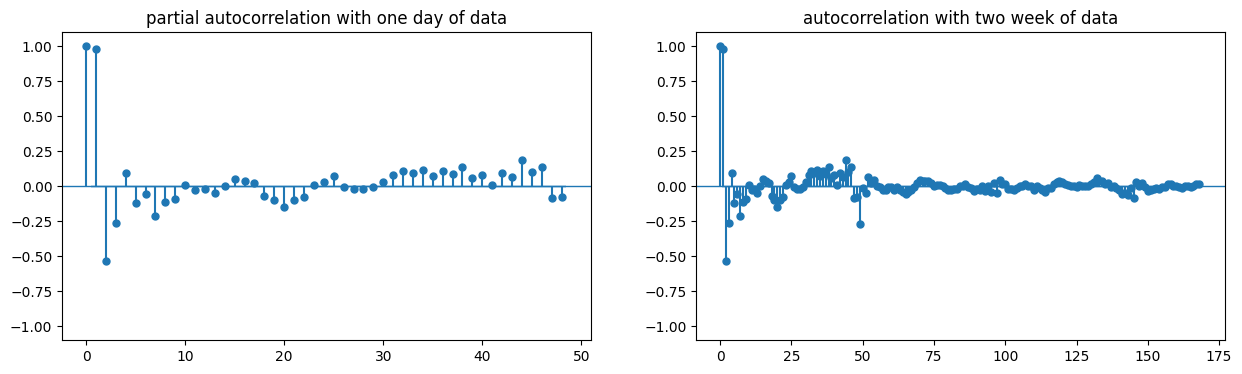

In [87]:

# Gráfico autocorrelación parcial
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes = axes.flat
plot_pacf(df_hour.travels, ax=axes[0], linewidth = 1, lags=48)
axes[0].set_title("partial autocorrelation with one day of data")
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(df_hour.travels, ax=axes[1], linewidth = 1, lags=168)
axes[1].set_title("autocorrelation with two week of data")
axes[1].set_ylim(-1.1, 1.1)
plt.show()

El análisis de la autocorrelación (ACF) y la autocorrelación parcial (PACF) de la serie temporal revela características significativas sobre su estructura. En el gráfico de la ACF, se observa un patrón de ondulación sinusoidal que tiende a decrecer hacia cero conforme aumentan los lags, sugiriendo la presencia de una componente estacional. En particular, los picos altos en los lags 12 y 24 indican correlaciones significativas en intervalos recurrentes, lo que sugiere que la serie se comporta de manera similar cada 12 horas, posiblemente influenciada por ciclos diarios o semidiarios, como los datos de actividad humana o variables meteorológicas.

Por otro lado, en el análisis de la PACF, se destaca que los primeros lags, especialmente el primero y el segundo, presentan autocorrelaciones significativas, con una rápida disminución en los siguientes lags, lo que indica que la serie tiene una estructura autoregresiva de bajo orden (AR(1)). Esta fuerte dependencia del valor inmediatamente anterior sugiere que el comportamiento de la serie está determinado en gran medida por su último valor, mientras que la rápida caída en los lags sugiere que esta dependencia disminuye rápidamente.

En conjunto, los resultados indican que la serie temporal presenta una clara estructura autoregresiva y una componente estacional, reflejando patrones recurrentes cada 12 horas. Esto sugiere que el fenómeno analizado está sujeto a influencias cíclicas que se repiten en intervalos regulares, lo que es característico de series temporales con componentes estacionales y autoregresivas.

## Zero Aproximation - Simple Linear Regression Model

## First Aproximation - Autoregresive Model - LGMBRegressor(RandomForest)

In [101]:
df_hour.dropna(axis=0,inplace=True)
df_hour_norm = normalize(df=df_hour)
lags = [1, 12]
forecaster = ForecasterAutoreg(regressor=LGBMRegressor(random_state=42, verbose=-1), lags=lags)
# Dividir los datos en entrenamiento (80%) y validación (20%)
#train_size= int(len(df_hour_norm) * 0.8)
#train_data_norm = df_hour_norm['travels'][:train_size]
#val_data_norm = df_hour_norm['travels'][train_size:]

train_size = int(len(df_hour_norm) * 0.8)
train_data = df_hour_norm['travels'][:train_size]
val_data = df_hour_norm['travels'][train_size:]


# Entrenar el modelo en los datos de entrenamiento
forecaster.fit(y=train_data)
# Predicciones en el conjunto de entrenamiento
train_predictions = forecaster.predict(steps=len(train_data))
# Predicciones en el conjunto de validación
val_predictions = forecaster.predict(steps=len(val_data))

# Calcular métricas en el conjunto de entrenamiento  "mean_squared_error"
train_rmse = np.sqrt(mean_squared_error(train_data, train_predictions))
train_mse = metrics.mean_squared_error(train_data, train_predictions)
train_mae = mean_absolute_error(train_data, train_predictions)
train_mape = mean_absolute_percentage_error(train_data, train_predictions)

# Calcular métricas en el conjunto de validación
val_rmse = np.sqrt(mean_squared_error(val_data, val_predictions))
val_mse = metrics.mean_squared_error(val_data, val_predictions)
val_mae = mean_absolute_error(val_data, val_predictions)
val_mape = mean_absolute_percentage_error(val_data, val_predictions)

# Imprimir los resultados
print("Métricas en el conjunto de entrenamiento:")
print(f"RMSE: {train_rmse}")
print(f"MSE: {train_mse}")
print(f"MAE: {train_mae}")
print(f"MAPE: {train_mape}")

print("\nMétricas en el conjunto de validación:")
print(f"RMSE: {val_rmse}")
print(f"MSE: {val_mse}")
print(f"MAE: {val_mae}")
print(f"MAPE: {val_mape}")


Métricas en el conjunto de entrenamiento:
RMSE: 0.2543260421897174
MSE: 0.0646817357358859
MAE: 0.20213889557748135
MAPE: 263747820438.11584

Métricas en el conjunto de validación:
RMSE: 0.2764481595723786
MSE: 0.07642358493095532
MAE: 0.22132961426987885
MAPE: 3.0393710284481363


In [95]:
print(train_data.tail())
print(val_data.head())

pickup_datetime
2024-03-13 12:00:00    0.469165
2024-03-13 12:30:00    0.449803
2024-03-13 13:00:00    0.425959
2024-03-13 13:30:00    0.461635
2024-03-13 14:00:00    0.487451
Name: travels, dtype: float64
pickup_datetime
2024-03-13 14:30:00    0.478308
2024-03-13 15:00:00    0.510398
2024-03-13 15:30:00    0.481535
2024-03-13 16:00:00    0.494442
2024-03-13 16:30:00    0.540158
Name: travels, dtype: float64


In [102]:
print(len(train_predictions))
print(len(train_data))
print(type(train_predictions))

#train_size = int(len(df_hour) * 0.8)
#train_data = df_hour_norm['travels'][:train_size]
#val_data = df_hour_norm['travels'][train_size:]

df_pred_train = pd.DataFrame(data=train_predictions)
df_pred_train.columns = ['travels']
df_pred_train.index = train_data.index


#df_pred_train.index = df_pred_train.index.shift(-5,freq='30min')  # Desplazar hacia abajo

df_pred_val = pd.DataFrame(data=val_predictions)
df_pred_val.columns = ['travels']
df_pred_val.index = val_data.index

print(type(df_pred_train))
print(type(train_data))

21005
21005
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


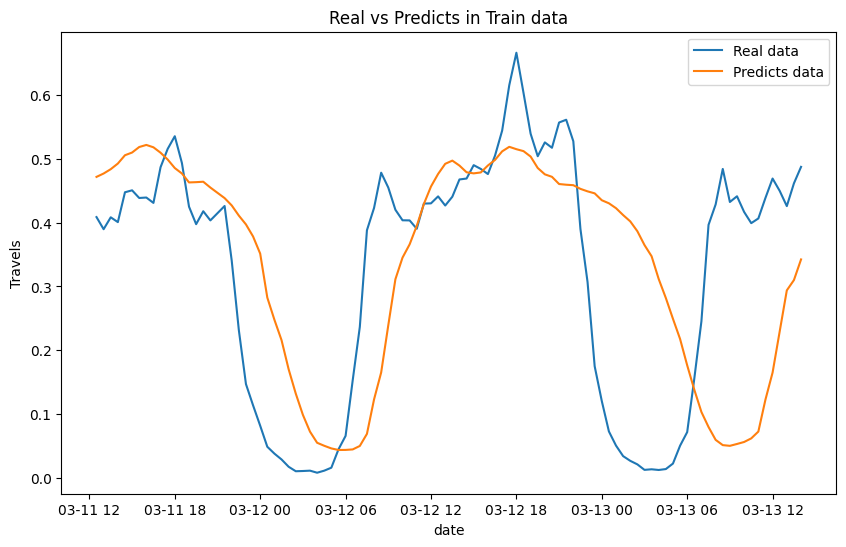

In [103]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=train_data[-100:], x=train_data.index[-100:], y=train_data.values[-100:], label="Real data", ax=ax)
sns.lineplot(data=df_pred_train[-100:], x=df_pred_train.index[-100:], y=df_pred_train['travels'][-100:], label="Predicts data", ax=ax)

# Ajustar la visualización
ax.set_title("Real vs Predicts in Train data")
ax.set_xlabel("date")
ax.set_ylabel("Travels")
plt.legend()
plt.show()

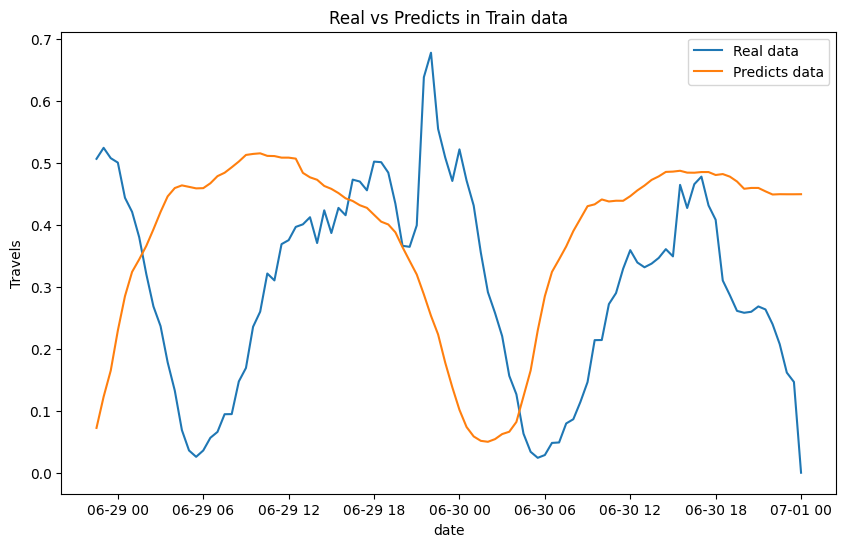

In [104]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=val_data[-100:], x=val_data.index[-100:], y=val_data.values[-100:], label="Real data", ax=ax)
sns.lineplot(data=df_pred_val[-100:], x=df_pred_val.index[-100:], y=df_pred_val['travels'][-100:], label="Predicts data", ax=ax)

# Ajustar la visualización
ax.set_title("Real vs Predicts in Train data")
ax.set_xlabel("date")
ax.set_ylabel("Travels")
plt.legend()
plt.show()